Figure 2A

By Harshaan Sekhon (sskhon2014@berkeley.edu)

The code below takes in two datasets and produces an averaged base-pairing probability matrix.

The two resources that this code relies upon are as follows:
    
1. **GCLiPP_clipper_2.0.bed**: The result of executing the Clipper 2.0 peak calling algorithm upon the processed sequencing file jurkat_all.bam. Clipper 2.0 release can be found within this github repository: https://github.com/YeoLab/clipper.

2. **hg38.2bit** sourced from https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/
https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.2bit

In [1]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from twobitreader import TwoBitFile
from tqdm import tqdm_notebook as tqdm
import pandas as pd



def sequence(coordinates):
    sequences = []
    genome = TwoBitFile("Resources/hg38.2bit")
    chroms = coordinates.column("chrom")
    starts = coordinates.column("start")
    stops = coordinates.column("stop")
    strands = coordinates.column("strand")
    for i in tqdm(np.arange(coordinates.num_rows)): 
        chrom = chroms[i]
        start = int(starts[i])
        stop = int(stops[i])
        strand = strands[i]
        chromid = genome[chrom]
        sequence = chromid[start-1:stop].lower().replace("t", "u")
        if strand == "-":
            sequence = complement(sequence)
        sequences.append(sequence)
    reads = coordinates.with_column("RNA sequences", sequences)
    return reads


def complement(dna):
    complement = {'a': 'u', 'c': 'g', 'g': 'c', 'u': 'a' ,'n':'n'}
    return ''.join([complement[base] for base in dna[::-1]])

In [3]:
from tqdm.notebook import tqdm


gclip = pd.read_csv('Resources/GCLiPP_clipper_2.0.bed', sep="\t", header=None)[[0,1,2, 5]]
gclip.columns = ["chrom", "start", "stop", "strands"]
gclip = gclip
gclip  = Table().from_df(gclip)
gclip

chrom,start,stop,strands
chr1,14056,14098,+
chr1,14412,14453,-
chr1,14576,14626,-
chr1,14662,14680,-
chr1,14991,15015,-
chr1,16332,16352,-
chr1,16869,16897,-
chr1,16970,16996,-
chr1,17324,17347,-
chr1,17849,17860,-


In [4]:
chrom = gclip.column("chrom")
center = np.asarray([int((i+j)/2) for i,j in zip(gclip.column("start"),gclip.column("stop"))])
start = center - 200 
stop = center + 200
strands = gclip.column("strands")
SEQs = sequence(Table().with_columns("chrom", chrom, "start", start, "stop", stop, "strand", strands))['RNA sequences']

  0%|          | 0/418102 [00:00<?, ?it/s]

In [5]:
def get_BPP(SEQz):
    import RNA
    pbar = tqdm.tqdm(total=len(SEQz))
    all_seq = []
    len_seq = len(SEQz[0])
    comp_matrx = np.zeros((200, 200))
    for seq in SEQz:
        pbar.update(1)
        (propensity,ensemble_energy) = RNA.pf_fold(seq)
        matrx = np.zeros((200, 200))
        for i in range(0, 201):
            for j in range(0, 201):
                matrx[i-1][j-1] = RNA.get_pr(i+100, j+100)
        comp_matrx = matrx + comp_matrx
    return comp_matrx/len(SEQz)

In [6]:
import time
import multiprocessing
from multiprocessing import Pool
import tqdm
import psutil

start_time = time.time()
cpu_cores = psutil.cpu_count(logical = True)
with Pool(processes=cpu_cores,maxtasksperchild=50) as pool:
    matricies = pool.map(get_BPP, np.asarray(np.array_split(SEQs,cpu_cores)))
stop_time = time.time()


pool.close()
pool.join()

  0%|          | 0/41810 [00:00<?, ?it/s]/opt/anaconda3/envs/py3forgi/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
100%|██████████| 41810/41810 [3:42:33<00:00,  3.13it/s]


In [7]:
matrix = sum(matricies)/len(matricies)

In [8]:
np.savetxt('BPP-Heatmap.txt',matrix)

<Figure size 720x360 with 0 Axes>

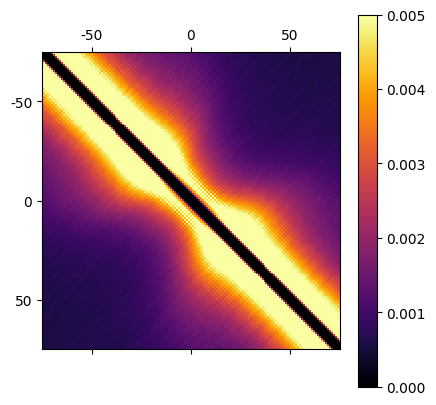

In [9]:
plt.figure(figsize=(10,5))
plt.style.use('default') 

plt.matshow(matrix, cmap="inferno",vmin=0, vmax=0.005) 

plt.colorbar()

plt.xlim(100-75,100+75)
plt.ylim(100+75, 100-75)

plt.xticks([50,100, 150])
plt.yticks([50,100, 150])

plt.xticks([50,100, 150],["-50", "0", "50"])
plt.yticks([50,100, 150],["-50", "0", "50"])
plt.savefig('BPP.pdf')

In [11]:
print('Total Runtime: ' + str(round(stop_time - start_time,2)) + ' seconds')

Total Runtime: 13354.27 seconds
